In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.data.datasets import ImgFlowOccFromFolder

In [4]:
def warp(img, flow):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow

        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow

        """
        B, C, H, W = img.size()
        # create mesh grid
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
        yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
        grid = torch.cat((xx, yy), 1).float()
        # cast into cuda
        if img.is_cuda:
            grid = grid.cuda()
        # require gradient
        grid.requires_grad = True
        vgrid = grid + flow
        # scale grid to [-1, 1] to support grid_sample function in pytorch
        # https://pytorch.org/docs/stable/nn.functional.html#grid-sample
        vgrid[:,0,:,:] = 2.0 * vgrid[:,0,:,:].clone() / max(W-1, 1) - 1.0
        vgrid[:,1,:,:] = 2.0 * vgrid[:,1,:,:].clone() / max(H-1, 1) - 1.0
        # permute vgrid to size [B, H, W, 2] to support grid_sample function
        vgrid = vgrid.permute(0, 2, 3, 1)
        
        output = F.grid_sample(img, vgrid, align_corners=False)
        
        return output

In [5]:
root = r'C:\Users\caodo\Desktop\TUM\data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
resize = transforms.Resize((540, 810))
dset = ImgFlowOccFromFolder(transform=transform, resize=resize, root=root, stack_imgs=True)
dataloader = DataLoader(dset, batch_size=1, shuffle=True)

In [23]:
imgs, flow, occ = next(iter(dataloader))
img1, img2 = imgs[:, 0, :, :], imgs[:, 1, :, :]

# warping
img_warped = warp(img2, flow)
img_occluded = (1 - occ) * img_warped 

photometric_error = (torch.abs(img_warped - img1) * (1 - occ)).sum() / (1 - occ).sum()
photometric_error

tensor(0.0392, grad_fn=<DivBackward0>)

Text(0.5, 1.0, 'occluded image')

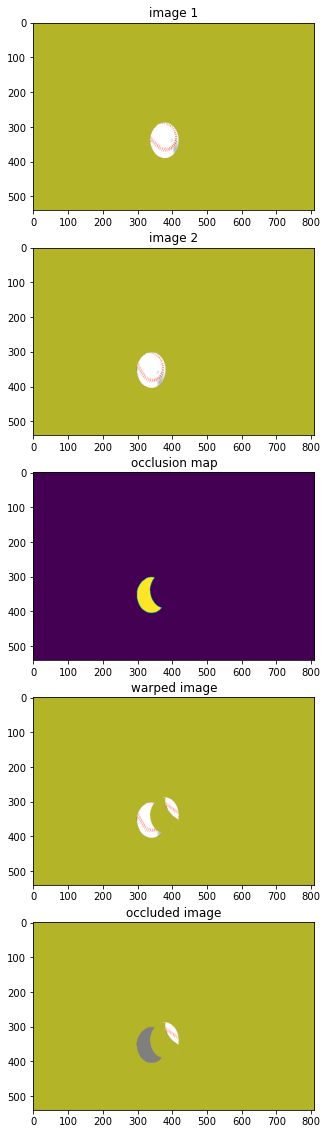

In [24]:
img_warped = img_warped.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_occluded = img_occluded.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img1 = img1.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img2 = img2.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
occ = occ.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(12, 4 * 5))
plt.subplot(5, 1, 1)
plt.imshow(img1/2.0 + 0.5)
plt.title('image 1')

plt.subplot(5, 1, 2)
plt.imshow(img2/2.0 + 0.5)
plt.title('image 2')

plt.subplot(5, 1, 3)
plt.imshow(occ)
plt.title('occlusion map')

plt.subplot(5, 1, 4)
plt.imshow(img_warped/2.0 + 0.5)
plt.title('warped image')

plt.subplot(5, 1, 5)
plt.imshow(img_occluded/2.0 + 0.5)
plt.title('occluded image')